In [1]:
from collections import deque
import random

In [2]:
import nbimporter
from fct_usuelles import lire_graphe, afficher_graphe, visualiser_graphe_par_etape

prends en paramètre un graphe dans un état (càd avec des sommets brulés) et retourne le graphe dans l'état suivante

In [3]:
def successeurs(graphe, etat_actuel):
    """
    Génère l'état suivant en propageant la brûlure aux voisins des sommets déjà brûlés.
    :param graphe: Le graphe sous forme de dictionnaire.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: Nouveau dictionnaire représentant l'état des sommets après propagation.
    """
    # Copier l'état actuel pour générer le nouvel état
    nouvel_etat = etat_actuel.copy()

    # Récupérer tous les sommets brûlés
    sommets_brules = [sommet for sommet, etat in nouvel_etat.items() if etat == "brulé"]

    # Propager la brûlure aux voisins des sommets brûlés
    for sommet in sommets_brules:
        for voisin in graphe.get(sommet, []):  # Obtenir les voisins dans la liste d'adjacence
            if nouvel_etat[voisin] == "non brûlé":  # Brûler uniquement les sommets non brûlés
                nouvel_etat[voisin] = "brulé"

    return nouvel_etat

test_but : vérifie si tout les sommets sont brulées

In [4]:
def test_but(etat_actuel):
    """
    Vérifie si tous les sommets du graphe sont brûlés.
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets (brûlés ou non brûlés).
    :return: True si tous les sommets sont brûlés, False sinon.
    """
    return all(etat == "brulé" for etat in etat_actuel.values())


In [5]:
def choisir_sommet_a_bruler(graphe, etat_actuel):
    """
    Sélectionne un sommet non brûlé ayant le maximum de voisins.
    
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_actuel: Dictionnaire contenant l'état actuel des sommets.
    :return: Le sommet non brûlé avec le maximum de voisins, ou None si aucun sommet disponible.
    """
    # Trouver les sommets non brûlés
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == "non brûlé"]
    
    if not sommets_non_brules:
        # Aucun sommet non brûlé
        return None

    # Trouver le sommet avec le maximum de voisins
    sommet_max_voisins = max(sommets_non_brules, key=lambda sommet: len(graphe.get(sommet, [])))

    return sommet_max_voisins


In [6]:
def choisir_sommet_aleatoire(etat_actuel):
    sommets_non_brules = [sommet for sommet, etat in etat_actuel.items() if etat == "non brûlé"]
    return random.choice(sommets_non_brules) if sommets_non_brules else None


## 1ère méthode

In [7]:
def recherche_profondeur(graphe, etat_initial, successeurs, test_but):
    """
    Algorithme générique de recherche pour brûler un graphe en choisissant un sommet par étape.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : créer la liste des états à traiter
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 0, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état
        noeud = etats_a_traiter.pop()

        noeud["etat"] = successeurs(graphe, noeud["etat"])

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Choisir un nouveau sommet à brûler activement
        nouveau_sommet = choisir_sommet_a_bruler(graphe, noeud["etat"])
        #nouveau_sommet = choisir_sommet_aleatoire(noeud["etat"])
        if nouveau_sommet is None:
            # Si aucun sommet à brûler n'est disponible, retourner l'état actuel
            continue

        # Marquer le nouveau sommet comme "brûlé"
        etat_suivant = noeud["etat"].copy()
        etat_suivant[nouveau_sommet] = "brulé"

        # Ajouter le nouvel état à la liste des états à traiter
        etats_a_traiter.append({
            "etat": etat_suivant,
            "cout": noeud["cout"] + 1,  # Chaque étape coûte 1
            "brules_actifs": noeud["brules_actifs"] + [nouveau_sommet]
        })

    # Si aucun état final n'est trouvé
    return [], float("inf")


etape 1 :

parcours en largeur : popleft de la liste des états à traiter

parcours en largeur itéré : livre artificial intelligence section 3.4.4 et 3.4.5


etape 2 : couverture des balles

apploqier le A* dans le parcours

bruler ce noeuds pendant un certain temps
=> couverture par des balles

l'ensemble des action : 
le cout : la taille de la grande balle
fixer burning number dés le début (6)


# 2

In [8]:
def recherche_largeur(graphe, etat_initial, successeurs, test_but):
    """
    Algorithme générique de recherche en largeur pour brûler un graphe.
    À chaque étape, chaque sommet est exploré pour générer tous les états possibles.
    :param graphe: Le graphe sous forme de dictionnaire (liste d'adjacence).
    :param etat_initial: Dictionnaire représentant l'état initial des sommets (brûlés ou non brûlés).
    :param successeurs: Fonction qui génère l'état suivant (propagation).
    :param test_but: Fonction qui vérifie si tous les sommets sont brûlés.
    :return: Chemin (liste des états successifs), sommets brûlés activement à chaque étape, et coût total.
    """
    # Initialisation : file (FIFO) pour gérer les états à traiter
    etats_a_traiter = deque([{"etat": etat_initial, "cout": 0, "brules_actifs": []}])

    while etats_a_traiter:
        # Extraire un état de la file (FIFO)
        noeud = etats_a_traiter.popleft()

        # Propager l'état courant (brûlage des voisins déjà brûlés)
        noeud["etat"] = successeurs(graphe, noeud["etat"])

        noeud["cout"] += 1  # Chaque étape coûte 1

        # Vérifier si tous les sommets sont brûlés
        if test_but(noeud["etat"]):
            return noeud["brules_actifs"], noeud["cout"]

        # Générer tous les nouveaux états possibles en brûlant chaque sommet non brûlé
        for sommet in graphe:
            if noeud["etat"].get(sommet) != "brulé":  # Si le sommet n'est pas encore brûlé
                # Copier l'état courant
                etat_suivant = noeud["etat"].copy()

                # Marquer le sommet comme "brûlé"
                etat_suivant[sommet] = "brulé"

                # Ajouter le nouvel état à la file
                etats_a_traiter.append({
                    "etat": etat_suivant,
                    "cout": noeud["cout"],
                    "brules_actifs": noeud["brules_actifs"] + [sommet]
                })

    # Si aucun état final n'est trouvé
    return None, [], float("inf")


In [9]:
# 10 sommets (3.16)
#fichier = r'instances\Stranke94\Stranke94.mtx'

# 29 sommets (5.38)
#fichier = r'instances\bn-mouse_visual-cortex_1\bn-mouse_visual-cortex_1.mtx'

# 34 sommets (5,83)
#fichier = r'instances\karate\karate.mtx'

# 7057 sommets (84.005)
fichier = r'instances\fb-pages-government\fb-pages-government.mtx'

# 11631 sommets (107.84)
#fichier = r'instances\web-wiki-crocodile\web-wiki-crocodile.mtx'

# 196 591 sommets (443.38)
#fichier = r'instances\loc-gowalla_edges\loc-gowalla_edges.mtx'

# Charger un graphe avec la fonction lire_graphe
graphe = lire_graphe(fichier)

In [10]:
#afficher_graphe(graphe)

In [ ]:
etat_initial = {sommet: "non brûlé" for sommet in graphe}

sommets_actifs, cout = recherche_profondeur(graphe, etat_initial, successeurs, test_but)

print("*********** Parcours en profondeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs)
print("Coût total:", cout)
print("\n")

sommets_actifs, cout = recherche_largeur(graphe, etat_initial, successeurs, test_but)

print("*********** Parcours en largeur ***********")
print("Sommets brûlés à chaque étape:", sommets_actifs)
print("Coût total:", cout)

*********** Parcours en profondeur ***********
Sommets brûlés à chaque étape: [5320, 6615, 1434, 5114, 4396, 467]
Coût total: 6




dire un sommet va etre brulé au 3 tour par exemple
notre solution (du 2eme algo) sera le  centre (sommet) de la boule ayant le rayon le plus grand

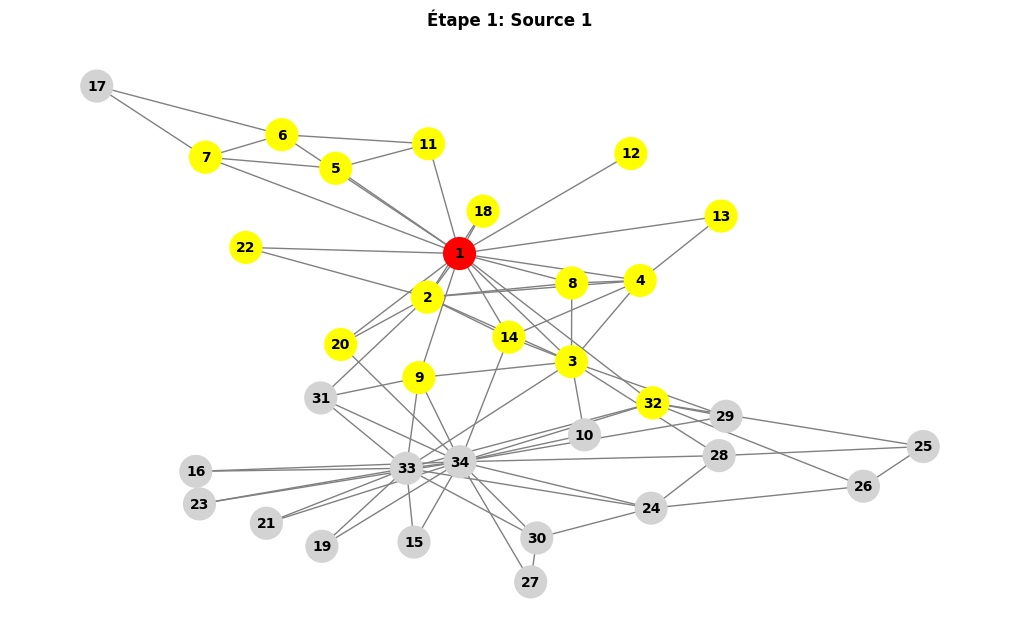

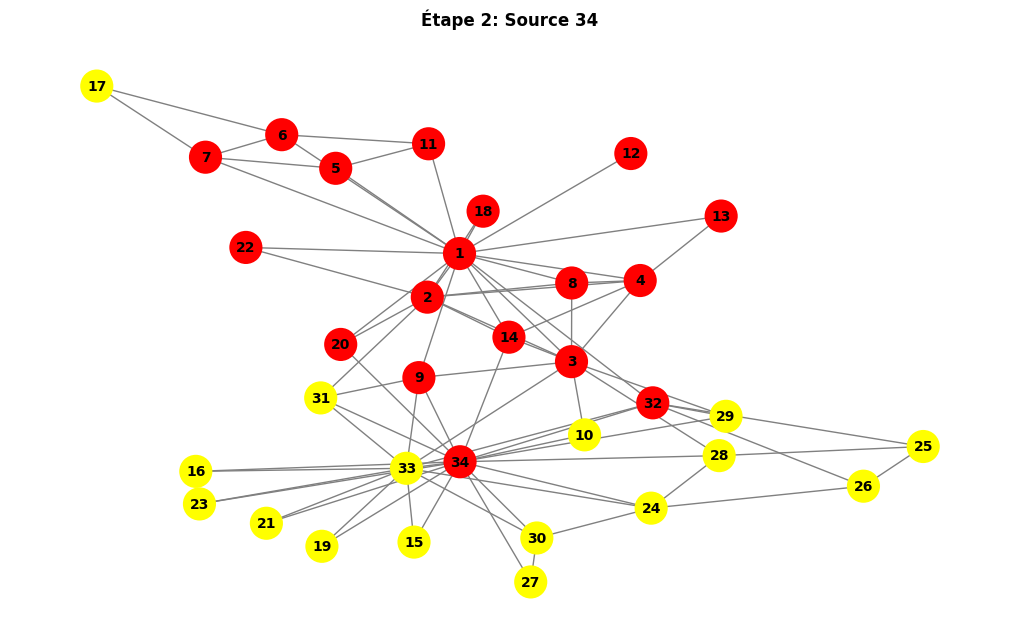

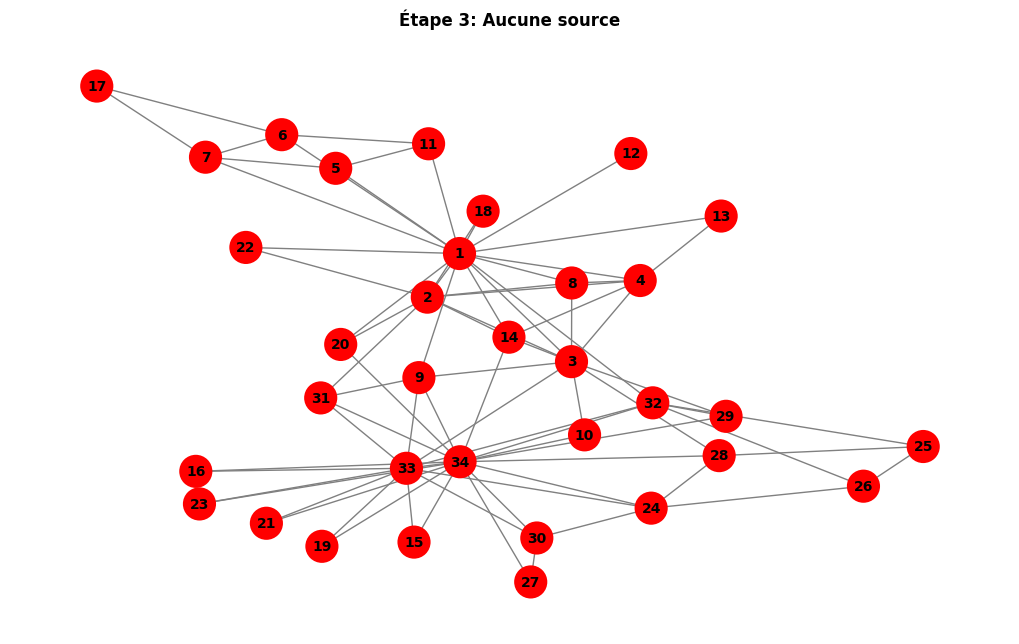

In [136]:
# Visualiser le graphe par étape
#visualiser_graphe_par_etape(graphe, sommets_actifs)
